In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dateutil.relativedelta import relativedelta
from datetime import datetime
import yfinance as yf

In [2]:
# Initialization
risk_tickers = [
    'ARKK', 'SPHB', 'BTC-USD', 'XBI', 'XLK', 'SOXX', 'XLY', 'IWM', 'EEM', 'HYG', 'USO', 'DBC', 'CPER', 'AUDJPY=X'
]
safe_tickers = [
    'TLT', 'BIL', 'SPLV', 'XLP', 'XLU', 'XLV', 'GLD'
]
benchmark = 'SPY'

In [3]:
def retrieve_all_prices_yf(risk_tickers, safe_tickers, end_date, frequency='M', benchmark='SPY', start_date=None):
    """
    Retrieve closing prices from Yahoo Finance for the given tickers.

    Parameters:
    risk_tickers (list): List of tickers for risk-on assets.
    safe_tickers (list): List of tickers for risk-off assets.
    end_date (str): The end date for the data retrieval in 'YYYY-MM-DD' format.
    frequency (str): Frequency for the data ('M' for monthly, 'W' for weekly).
    benchmark (str): Ticker symbol for the benchmark.
    start_date (str, optional): The start date for data retrieval in 'YYYY-MM-DD' format.

    Returns:
    tuple: Three DataFrames containing prices for risk assets, safe assets, and the benchmark.
    """
    # Determine start date if not supplied
    if not start_date:
        if frequency == 'M':
            start_date = (datetime.strptime(end_date, '%Y-%m-%d') - relativedelta(months=15, days=1)).date()
        else:
            start_date = (datetime.strptime(end_date, '%Y-%m-%d') - relativedelta(weeks=15, days=1)).date()

    # Download function for tickers
    def download_prices(tickers):
        prices = pd.DataFrame()
        for ticker in tickers:
            prices[ticker] = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
        prices.index = pd.to_datetime(prices.index)
        return prices

    # Retrieve prices for each group of tickers
    risk_prices = download_prices(risk_tickers)
    safe_prices = download_prices(safe_tickers)
    benchmark_prices = yf.download(benchmark, start=start_date, end=end_date)['Adj Close'].to_frame(name=benchmark)
    benchmark_prices.index = pd.to_datetime(benchmark_prices.index)

    return risk_prices, safe_prices, benchmark_prices

In [4]:
def calculate_standardized_period_returns(risk_prices, safe_prices, benchmark_prices, frequency='M',
                                          reverse_order=False):
    """
    Calculate standardized returns of ETFs relative to a benchmark.

    Parameters:
    risk_prices (DataFrame): Prices for risk-on ETFs.
    safe_prices (DataFrame): Prices for risk-off ETFs.
    benchmark_prices (DataFrame): Prices for the benchmark ETF.
    frequency (str): 'M' for monthly, 'W' for weekly.
    reverse_order (bool): Reverse column order if True.

    Returns:
    DataFrame: Standardized returns for the ETFs.
    """
    # Standardize prices relative to the benchmark
    risk_rel_strength = risk_prices.div(benchmark_prices.iloc[:, 0], axis=0)
    safe_rel_strength = safe_prices.div(benchmark_prices.iloc[:, 0], axis=0)

    # Resample and calculate percentage change
    change_func = lambda x: x.resample(frequency).last().pct_change()
    risk_monthly_change = change_func(risk_rel_strength)
    safe_monthly_change = change_func(safe_rel_strength)

    # Combine and format the final DataFrame
    combined_monthly_change = pd.concat([risk_monthly_change, safe_monthly_change], axis=1).dropna()
    return combined_monthly_change.T.iloc[:, ::-1] if reverse_order else combined_monthly_change

In [5]:
def calculate_rolling_correlations(returns_df, window=12):
    """
    Calculate rolling correlations for each ticker pair within a specified window.

    Parameters:
    returns_df (DataFrame): DataFrame containing returns data for tickers.
    window (int): Rolling window size in terms of number of periods.

    Returns:
    dict: Dictionary containing rolling correlation matrices keyed by date.
    """
    rolling_corr_dict = {}
    for start in range(len(returns_df) - window + 1):
        end = start + window
        window_data = returns_df.iloc[start:end]
        corr_matrix = window_data.corr()
        rolling_corr_dict[returns_df.index[end - 1]] = corr_matrix
    return rolling_corr_dict

In [6]:
def calculate_avg_corr_stability(rolling_corr_dict):
    """
    Calculate the average correlation and stability (standard deviation) from rolling correlation data.

    Parameters:
    rolling_corr_dict (dict): Dictionary with dates as keys and correlation matrices as values.

    Returns:
    tuple: Two DataFrames containing average correlations and stability.
    """
    corr_matrices = list(rolling_corr_dict.values())
    avg_corr = pd.DataFrame(np.mean(corr_matrices, axis=0), index=corr_matrices[0].index,
                            columns=corr_matrices[0].columns)
    stability_corr = pd.DataFrame(np.std(corr_matrices, axis=0), index=corr_matrices[0].index,
                                  columns=corr_matrices[0].columns)
    return avg_corr, stability_corr

In [7]:
def plot_correlation_heatmaps(avg_corr, stability_corr, title_suffix=''):
    """
    Plot heatmaps for average correlation and correlation stability.

    Parameters:
    avg_corr (DataFrame): DataFrame containing average correlations.
    stability_corr (DataFrame): DataFrame containing correlation stability.
    title_suffix (str): Suffix to add to the heatmap titles.
    """
    for data, title in zip([avg_corr, stability_corr], ['Average Correlation', 'Correlation Stability']):
        fig, ax = plt.subplots(figsize=(15, 10))
        sns.heatmap(data, annot=True, fmt=".2f", cmap='BuPu', linewidths=0.5, linecolor='black', ax=ax)
        ax.set_title(f'{title} {title_suffix}')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        plt.setp(ax.get_yticklabels(), rotation=0, ha='right')
        plt.show()

In [8]:
def plot_simplified_clustermap(data, title):
    """
    Plot a simplified clustermap of the data.

    Parameters:
    data (DataFrame): DataFrame containing data to be clustered.
    title (str): Title for the clustermap.
    """
    cluster = sns.clustermap(data, figsize=(20, 20), cmap='BuPu', linewidths=1, linecolor='black',
                             dendrogram_ratio=(.1, .2), tree_kws={'linewidths': 2}, cbar=False)
    cluster.cax.set_visible(False)
    plt.setp(cluster.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=20)
    plt.setp(cluster.ax_heatmap.get_yticklabels(), rotation=0, ha='left', fontsize=20)
    plt.subplots_adjust(bottom=0.15, top=0.85, left=0.15, right=0.85)
    plt.suptitle(title, color='black', fontsize=20, va='top', ha='center', y=0.95)
    plt.show()

[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


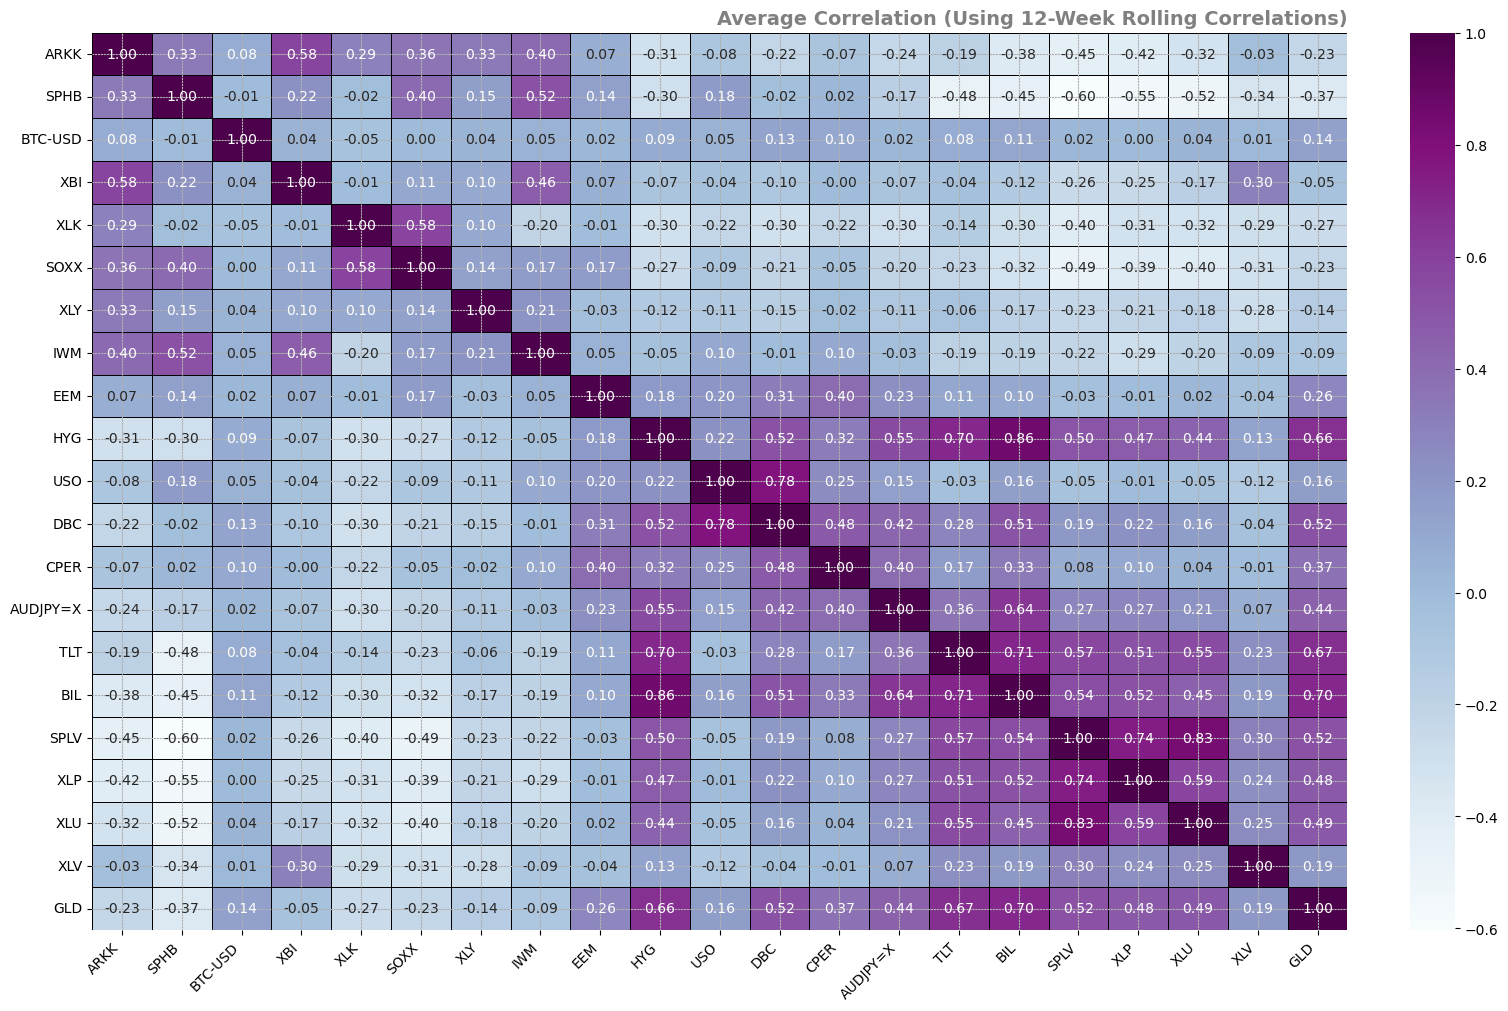

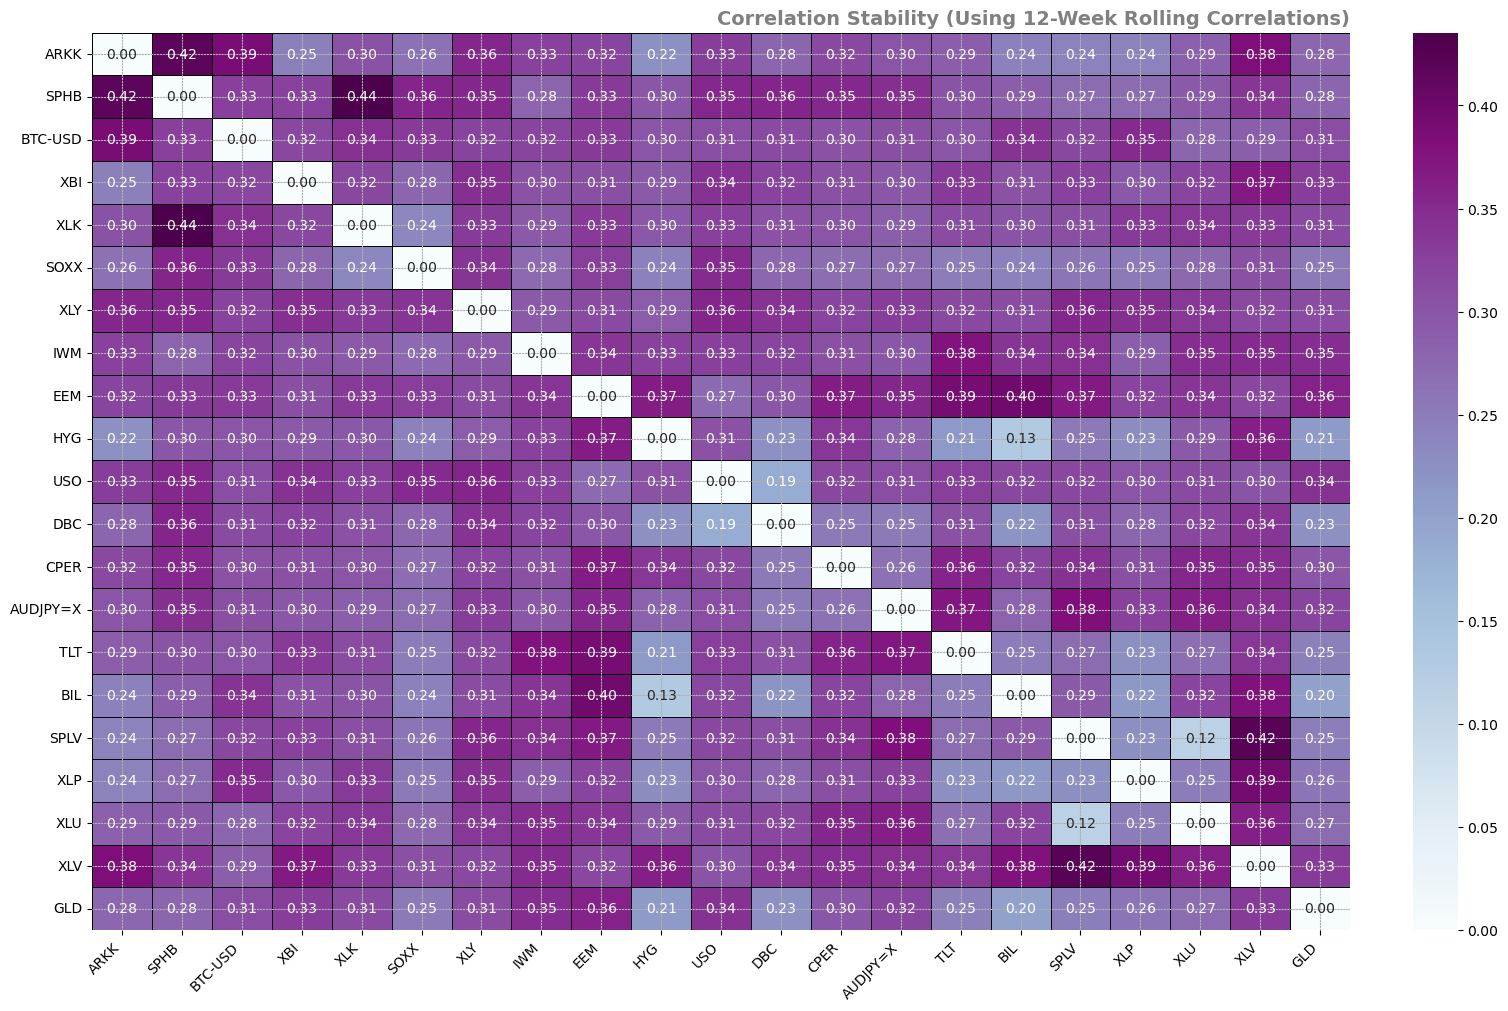

d:\Anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.draw()
d:\Anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.draw()
d:\Anaconda3\lib\site-packages\seaborn\matrix.py:1113: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(**tight_params)
C:\Users\Wonyoung\AppData\Local\Temp\ipykernel_7924\1419622948.py:14: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=0.15, top=0.85, left=0.15, right=0.85)
d:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.c

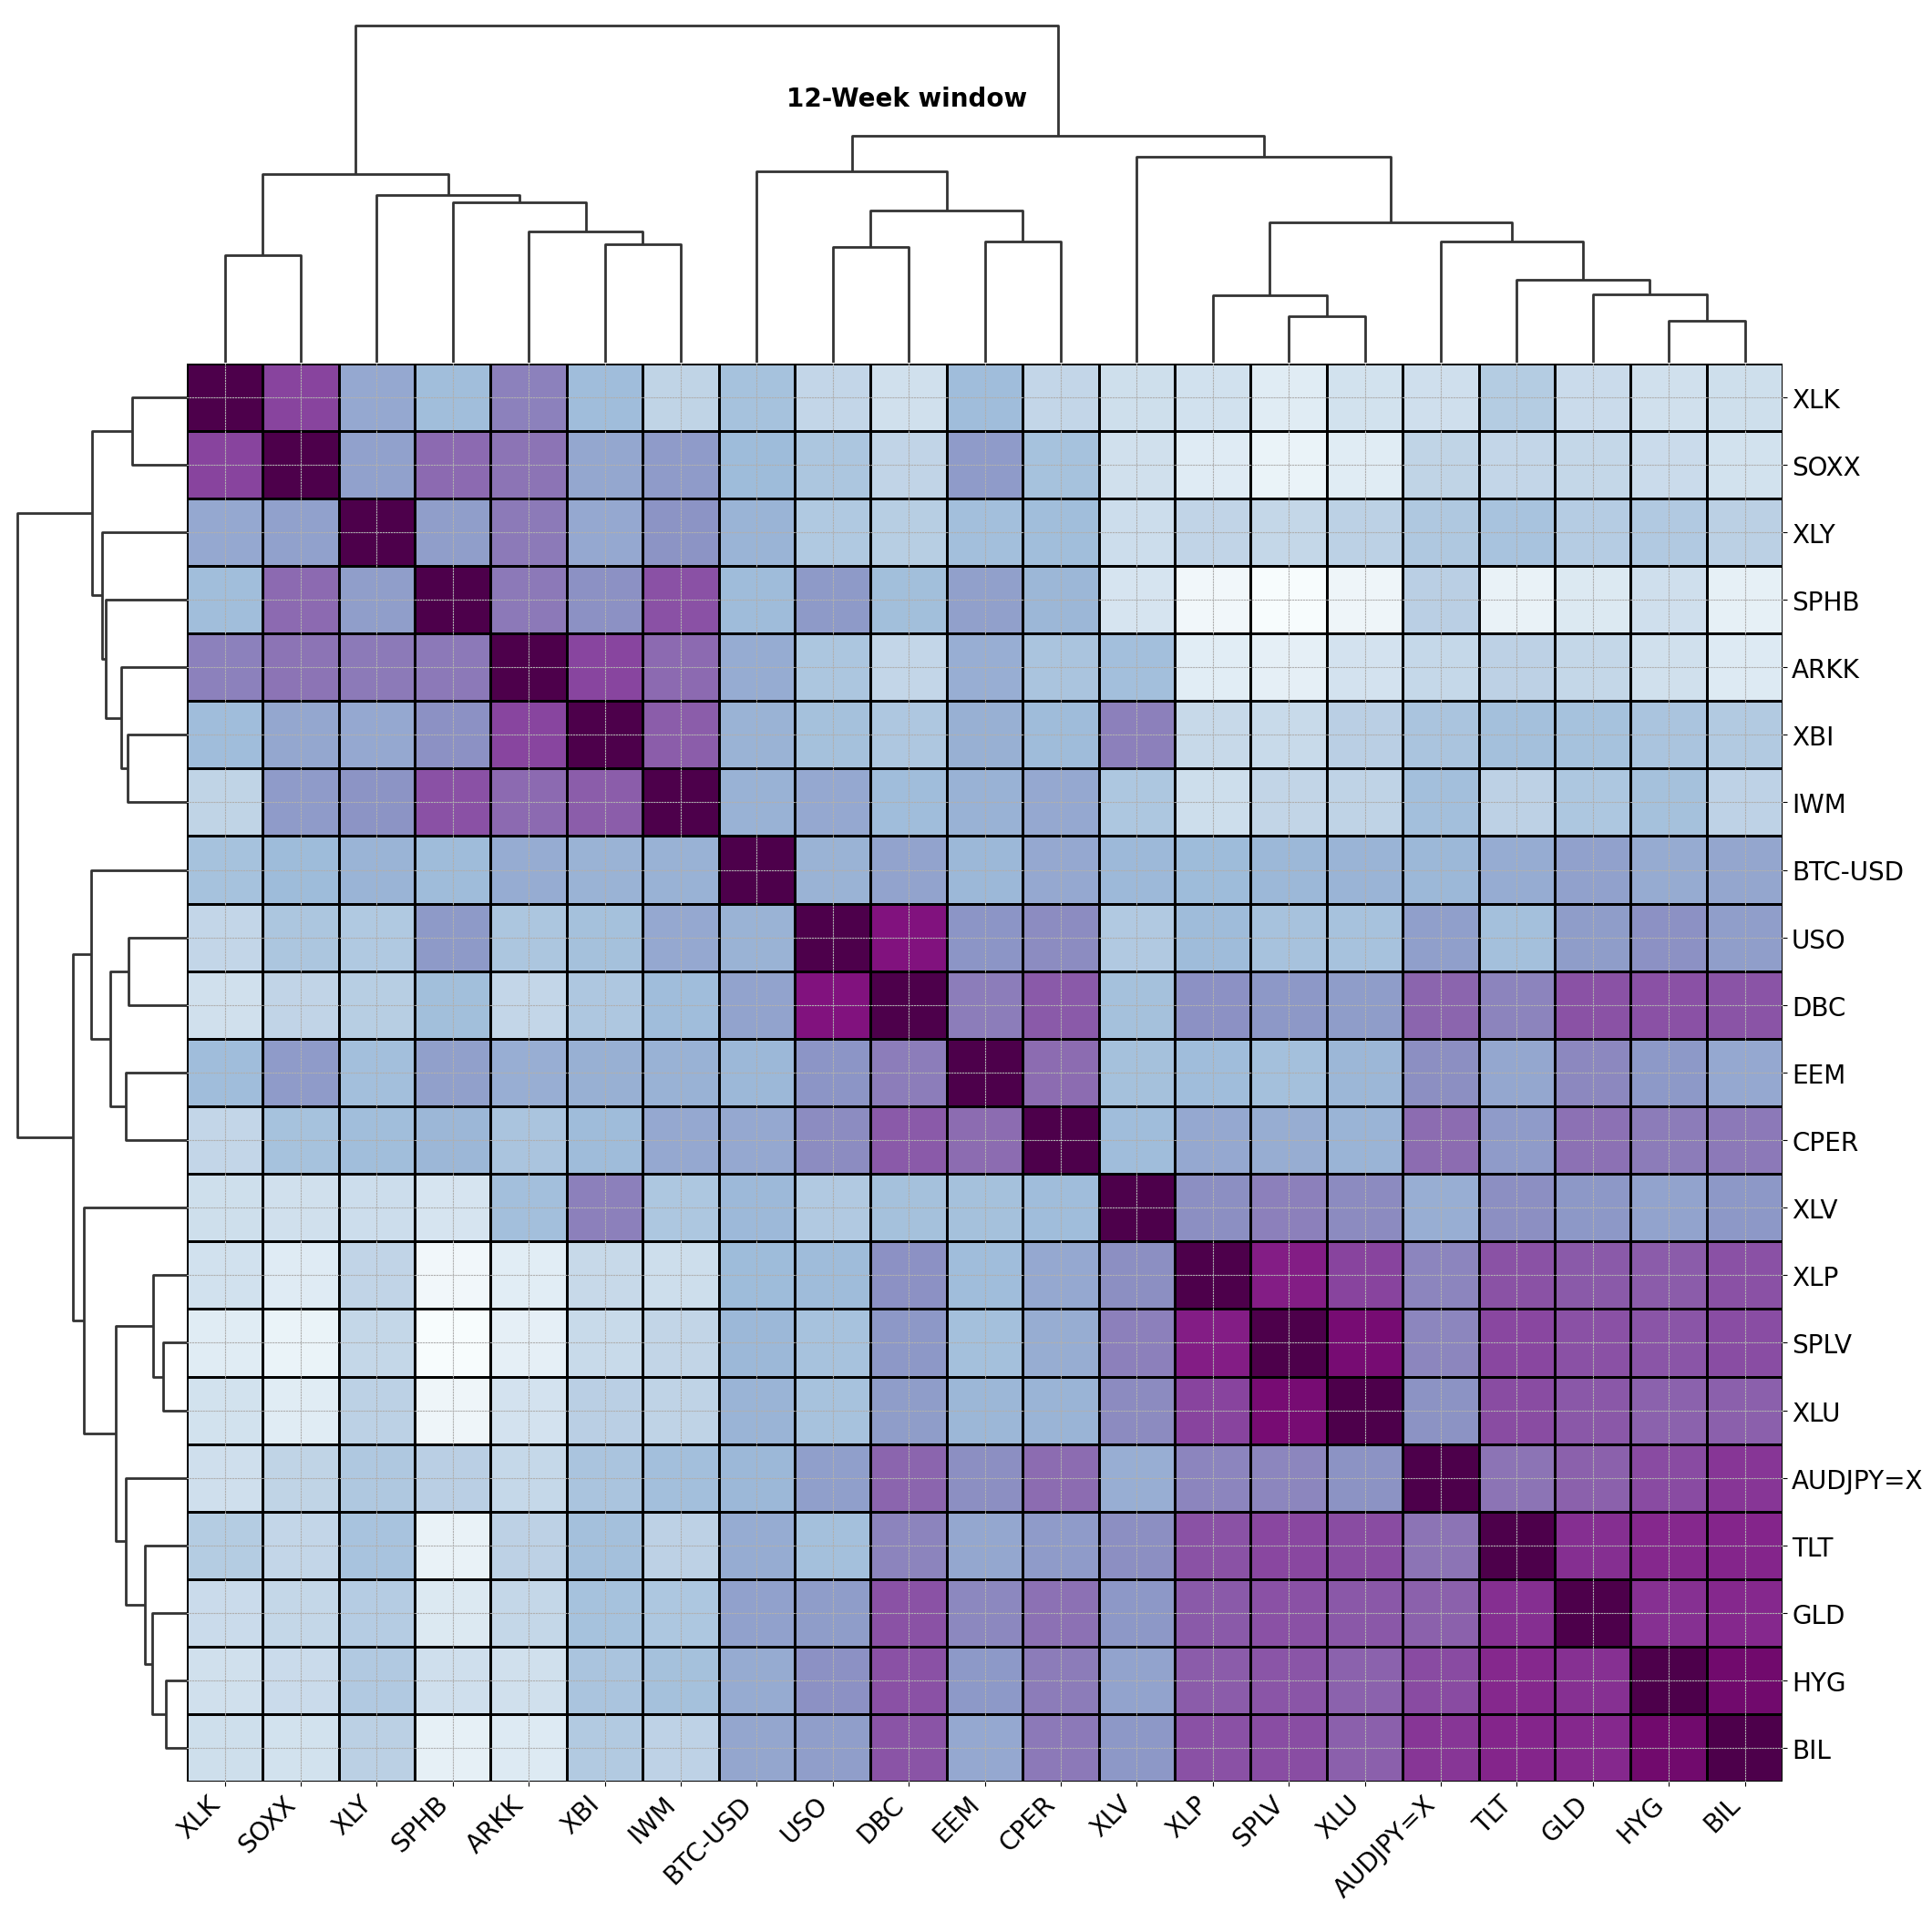

In [9]:
start_date = '2014-06-17'
end_date = '2024-06-17'
frequency = 'W'

# Retrieve prices with longer histories
risk_prices, safe_prices, benchmark_prices = retrieve_all_prices_yf(risk_tickers, safe_tickers, end_date,
                                                                    frequency=frequency,
                                                                    benchmark='SPY',
                                                                    start_date=start_date)

# standardize performance, take transpose
final_df = calculate_standardized_period_returns(risk_prices, safe_prices, benchmark_prices, frequency=frequency)

window = 12  # select the window you want to assess
period_label = 'Week' if frequency == 'W' else 'Month'
rolling_correlations = calculate_rolling_correlations(final_df, window)
avg_corr, stability_corr = calculate_avg_corr_stability(rolling_correlations)
plot_correlation_heatmaps(avg_corr, stability_corr,
                          title_suffix=f'(Using {window}-{period_label} Rolling Correlations)')
plot_simplified_clustermap(avg_corr, title=f'{window}-{period_label} window')